<a href="https://colab.research.google.com/github/bcataldo3/plantilla_curso_python/blob/main/docs/Clase_10 - Detección de Anomalias - Introducción.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de Anomalias - Introducción

El tema principal de este capítulo es la detección automática de anomalías sin ninguna supervisión. Dado que los modelos no se basan en la retroalimentación proporcionada por muestras etiquetadas, solo podemos confiar en las propiedades de todo el conjunto de datos para descubrir las similitudes y resaltar las diferencias. En particular, partimos de una suposición muy simple pero efectiva: los eventos comunes son normales, mientras que los eventos poco probables suelen tratarse como anomalías. Por supuesto, esta definición implica que el proceso que estamos monitoreando está funcionando correctamente y la mayoría de los resultados se consideran válidos. Por ejemplo: una fábrica de procesamiento de silicio debe cortar una oblea en trozos iguales. Sabemos que cada uno de ellos mide 0.2 × 0.2 pulgadas (aproximadamente 0.5 × 0.5 cm) con una desviación estándar de 0.001 pulgadas para cada lado. Esta medida se ha determinado después de 1,000,000 pasos de procesamiento. ¿Estamos autorizados a considerar un chip de 0.25 × 0.25 pulgadas como una anomalía? Por supuesto que sí. De hecho, supongamos que la longitud de cada lado se modela como una distribución gaussiana (una elección muy razonable) con $μ = 0.2$ y $σ = 0.001$; después de tres desviaciones estándar, la probabilidad cae casi a cero. Por lo tanto, por ejemplo: $P(lado > 0.23) ≈ 0$ y un chip con tales dimensiones debe considerarse claramente como una anomalía.

Obviamente, este es un ejemplo extremadamente sencillo que no necesita ningún modelo. Sin embargo, en casos de la vida real, la estructura de las densidades puede ser muy compleja, con varias regiones de alta probabilidad rodeadas por otras de baja probabilidad. Por eso se deben emplear enfoques más genéricos para modelar todo el espacio muestral.

Por supuesto, la semántica de las anomalías no puede estandarizarse y siempre depende del problema específico que se esté analizando. Por esta razón, una forma común de definir el concepto de anomalías es hacer una distinción entre valores atípicos y novedades. Los primeros son muestras incluidas en el conjunto de datos, incluso si la distancia entre ellos y las demás muestras es mayor que el promedio. Por lo tanto, un proceso de detección de valores atípicos tiene como objetivo descubrir tales muestras extrañas (por ejemplo: considerando el ejemplo anterior, un chip de $0.25 × 0.25$ pulgadas es claramente un valor atípico si está incluido en el conjunto de datos). En cambio, el objetivo de la detección de novedades es ligeramente diferente, porque en este caso asumimos que trabajamos con un conjunto de datos que contiene solo muestras normales; por lo tanto, dado uno nuevo, nos interesa entender si podemos considerarlo como proveniente del proceso original de generación de datos o como un valor atípico (por ejemplo: un técnico novato nos pregunta esto: ¿es un chip de $0.25 × 0.25$ pulgadas un valor atípico? Si hemos recopilado un conjunto de datos de chips normales, podemos usar nuestro modelo para responder la pregunta).

Otra forma de describir este escenario es considerar las muestras como una serie de valores que pueden ser afectados por ruido variable: $y(t) = x(t) + n(t)$. Cuando $||n(t)|| << ||x(t)||$, las muestras pueden clasificarse como limpias: $y(t) ≈ x(t)$. Por el contrario, cuando $||n(t)|| ≈ ||x(t)||$ (o incluso es mayor), son valores atípicos que no pueden representar fielmente el verdadero proceso subyacente pdata. Dado que la magnitud promedio del ruido suele ser considerablemente menor que la señal, la probabilidad de que $P(||n(t)|| ≈ ||x(t)||)$ sea cercana a cero. Por lo tanto, podemos imaginar las anomalías como muestras normales afectadas por un ruido externo anormal. La diferencia real principal entre el manejo de una anomalía y una muestra ruidosa suele radicar en la capacidad para detectar las verdaderas anomalías y etiquetar las muestras en consecuencia. De hecho, aunque las señales ruidosas están definitivamente corrompidas y el objetivo es minimizar el impacto del ruido, las anomalías pueden ser identificadas con mucha frecuencia por seres humanos y etiquetadas correctamente. Sin embargo, como ya se discutió en este capítulo, estamos interesados en encontrar métodos de descubrimiento que no dependan de etiquetas existentes. Además, para evitar confusiones, siempre nos referimos a anomalías, definiendo cada vez el contenido del conjunto de datos (solo valores normales o valores normales y valores atípicos) y el objetivo de nuestro análisis. En la próxima sección, discutiremos brevemente la estructura esperada de los conjuntos de datos.

## Estructuras de los datos

En las tareas estándar supervisadas (y a menudo también no supervisadas), se espera que el conjunto de datos esté equilibrado. En otras palabras, el número de muestras pertenecientes a cada clase debería ser casi el mismo. En las tareas que discutiremos en este capítulo, en cambio, asumimos tener conjuntos de datos $X$ muy desequilibrados (que contienen $N$ muestras):

$N_{outliers} << N$, si hay una detección de valores atípicos (es decir, el conjunto de datos está parcialmente contaminado; por lo tanto, necesitamos encontrar una forma de filtrar todos los valores atípicos)
$N_{outliers} = 0$ (o, de manera más realista, $P(N_{outliers} > 0) → 0)$, si hay una detección de novedades (es decir, generalmente podemos confiar en las muestras existentes y enfocar nuestra atención en las nuevas)

La razón de estos criterios es bastante obvia: consideremos el ejemplo discutido anteriormente. Si la tasa de anomalías observada después de 1,000,000 pasos de procesamiento es igual al 0.2%, hay 2,000 anomalías, lo que puede ser un valor razonable para un proceso de trabajo. Si ese número es mucho más grande, significa que debería haber un problema más serio en el sistema, que va más allá del rol de un científico de datos. Por lo tanto, en tales casos, esperamos un conjunto de datos que contenga un gran número de muestras correctas y un número mucho menor de anomalías (o incluso cero). En muchos casos, la regla general es reflejar el proceso subyacente de generación de datos y, por lo tanto, si un experto puede confirmar, por ejemplo, tener anomalías del 0.2%, la proporción debería ser de 1000÷2 para encontrar una función de densidad de probabilidad realista. En tales casos, de hecho, es más importante descubrir los factores que determinan la distinción de los valores atípicos.

Por otro lado, si solo se nos solicita realizar una detección de novedades (por ejemplo: distinguir entre solicitudes de red válidas y maliciosas), el conjunto de datos debe ser validado para no contener anomalías, pero al mismo tiempo reflejar el verdadero proceso de generación de datos responsable de todas las posibles muestras válidas.

De hecho, si la población de las muestras correctas es exhaustiva, cualquier desviación grande de la región de alta probabilidad puede ser suficiente para activar una alarma. Por el contrario, una región limitada del verdadero proceso de generación de datos podría llevar a resultados falsos positivos (es decir, muestras válidas que no han sido incluidas en el conjunto de entrenamiento y se identifican erróneamente como valores atípicos). En el peor de los casos, un subconjunto muy ruidoso también podría provocar falsos negativos si las características están alteradas (es decir, valores atípicos que se identifican erróneamente como muestras válidas). Sin embargo, en la mayoría de los casos de la vida real, los factores más importantes son el número de muestras y el contexto desde el cual se recopilan. Es evidente que cualquier modelo debe ser entrenado con el mismo tipo de elementos que se van a probar.

Por ejemplo, si se toma una medida dentro de una planta química utilizando un instrumento de baja precisión, las pruebas recopiladas con uno de alta precisión podrían no ser representativas de la población (aunque, por supuesto, son mucho más confiables que el conjunto de datos). Por lo tanto, antes de realizar un análisis, sugiero encarecidamente verificar la naturaleza de los datos y también preguntar si todas las muestras de prueba se han extraído del mismo proceso de generación de datos.

Ahora podemos introducir el concepto de histogramas, que es la forma más sencilla de estimar la distribución de un conjunto de datos que contiene observaciones.

## Histogramas

La forma más simple de obtener una aproximación de la función de densidad de probabilidad se basa en un conteo de frecuencia. Si tenemos un conjunto de datos $X$ que contiene $m$ muestras $x_i ∈ ℜ$ (para simplificar, estamos considerando solo distribuciones univariadas, pero el proceso es exactamente equivalente para muestras multidimensionales), podemos definir $m$ y $M$ de la siguiente manera:

$m=\min\limits_{x_i \in X}\{x_i\} \: \text{ and } \: M=\max\limits_{x_i \in X}\{x_i\}$

El intervalo $(m, M)$ se puede dividir en un número fijo de intervalos $b$ (que pueden tener anchos iguales o diferentes, denotados como $w(b_j)$), de manera que $n_p(b_j)$ corresponde al número de muestras incluidas en el intervalo $b_j$. En este punto, dado una muestra de prueba $x_t$, es fácil entender que la aproximación de la probabilidad se puede obtener fácilmente detectando el intervalo que contiene $x_t$ y usando la siguiente fórmula:

$ p(x)=\frac{1}{m}\frac{n_p(b_t)}{w(b_t)}$

Antes de analizar los pros y los contras de este enfoque, consideremos un ejemplo simple basado en la distribución de las edades de las personas subdivididas en 10 clases diferentes:
El array ``ages`` contiene todas las muestras, y queremos crear un histograma para obtener una visión inicial de la distribución. Vamos a emplear la función ``np.histogram()`` de ``NumPy``, que proporciona todas las herramientas necesarias. El primer problema a resolver es determinar el número óptimo de intervalos. Esto puede ser fácil para distribuciones estándar, pero puede ser extremadamente difícil cuando no hay conocimiento previo sobre la densidad de probabilidad. La razón es sencilla: dado que necesitamos aproximar una función continua con una escalonada, el ancho de los intervalos determina la precisión final.

Por ejemplo: si la densidad es plana (por ejemplo: una distribución uniforme), unos pocos intervalos son suficientes para obtener un buen resultado. Por el contrario, cuando hay picos, es útil colocar más intervalos (más cortos) en las áreas donde la primera derivada de la función es grande y un número menor cuando la derivada está cerca de cero (indicando una región plana). Como vamos a discutir, este proceso se vuelve más fácil utilizando técnicas más sofisticadas, mientras que los histogramas generalmente se basan en cálculos más aproximados del número óptimo de intervalos. En particular, ``NumPy`` permite configurar el parámetro ``bins='auto'``, que fuerza al algoritmo a seleccionar automáticamente el número según un método estadístico bien definido (basado en el Estimador Freedman Diaconis y la fórmula de Sturges):

$n_{intervalos}=\max{\biggl( 1 + \log_2{m},\frac{2IQR}{\sqrt[3]{m}}  \biggr)}$

En la fórmula anterior, el rango intercuartílico (IQR) corresponde a la diferencia entre el percentil 75 y el percentil 25.

El siguiente código genera una data aleatoria de edades que llamaresmos ``ages``. Dado que no tenemos una idea clara sobre la distribución, preferimos confiar en la selección automática.


Histograms counts: [177  86 122 165 236 266 262 173 269 258 241 116 458 257 311   1   1   5
   6]
Bin edges: [16.  18.7 21.5 24.2 26.9 29.7 32.4 35.2 37.9 40.6 43.4 46.1 48.8 51.6
 54.3 57.1 59.8 62.5 65.3 68. ]


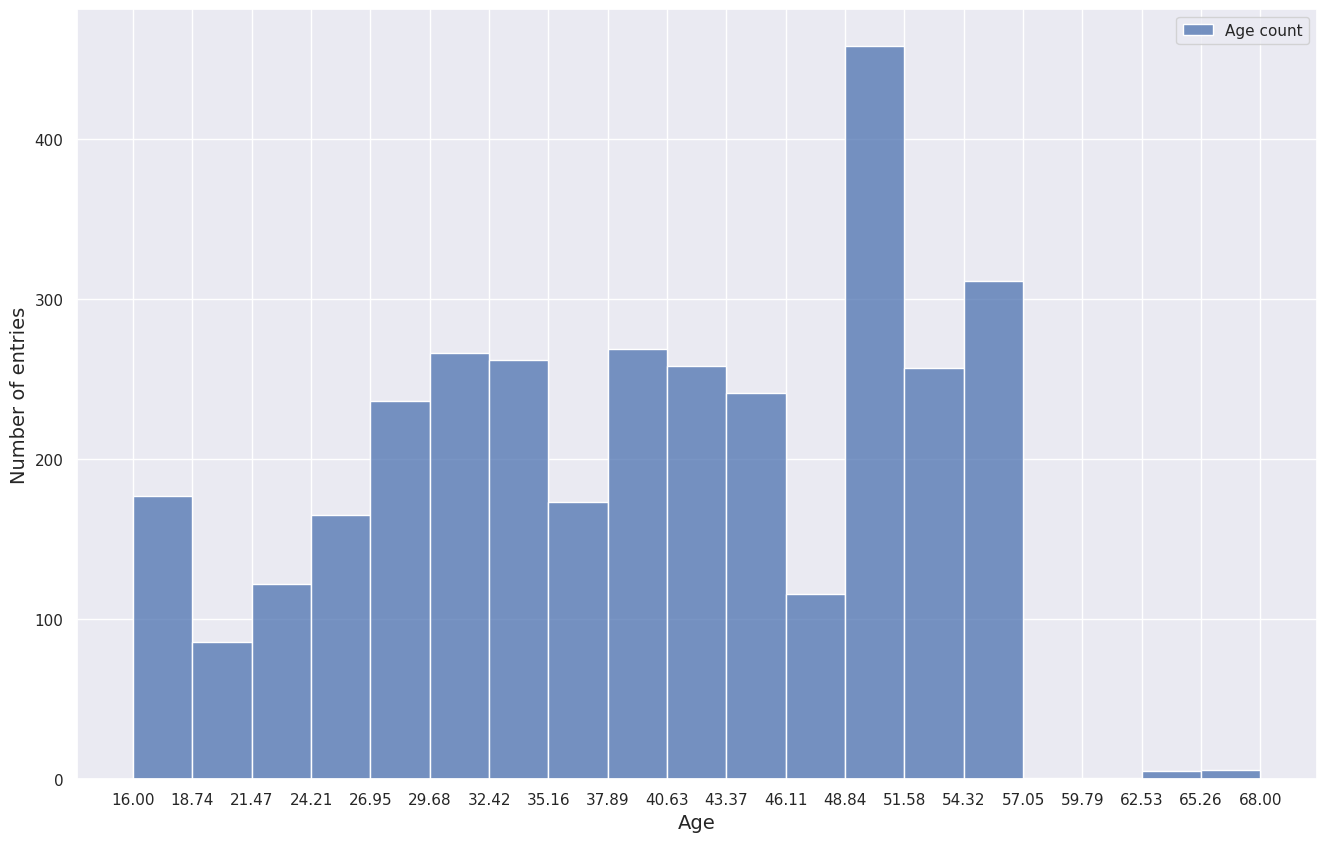

In [4]:
# Importe librerias
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Establecemos una semilla para reproducibilidad
np.random.seed(1000)

# Generacion del dataset artificial ages
nb_samples = [1000, 800, 500, 380, 280, 150, 120, 100, 50, 30]
ages = []
for n in nb_samples:
    i = np.random.uniform(10, 80, size=2)
    a = np.random.uniform(i[0], i[1], size=n).astype(np.int32)
    ages.append(a)
ages = np.concatenate(ages)

# Calculo de histograma
h, e = np.histogram(ages, bins='auto')
print('Histograms counts: {}'.format(h))
print('Bin edges: {}'.format(e.round(1)))

# Mostramos el histograma
sns.set()
fig, ax = plt.subplots(figsize=(16, 10))
sns.histplot(ages, kde=False, ax=ax, label='Age count')
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Number of entries', fontsize=14)
ax.set_xticks(e)
ax.legend()
plt.show()

El algoritmo ha definido 19 intervalos y ha mostrado tanto los recuentos de frecuencia como los límites (es decir, el valor mínimo es 16, mientras que el máximo es 68).


In [3]:
# Calculo de la probabilidad para un intervalo
d = e[1] - e[0]
p50 = float(h[12]) / float(ages.shape[0])
print('P(48.84 < x < 51.58) = {:.2f} ({:.2f}%)'.format(p50, p50 * 100.0))

P(48.84 < x < 51.58) = 0.13 (13.43%)


Por lo tanto, la aproximación de la probabilidad es aproximadamente del 13.5%, lo que también es confirmado por la estructura del histograma. Sin embargo, el lector debería haber comprendido claramente que este método tiene limitaciones evidentes. La primera y más obvia se refiere al número y el ancho de los intervalos. Un número pequeño, de hecho, produce resultados aproximados que no pueden tener en cuenta las oscilaciones rápidas. Por otro lado, un número muy grande conduce a un histograma con agujeros, porque la mayoría de los intervalos no contendrán muestras. Por lo tanto, se necesita un enfoque más sólido, considerando todas las dinámicas posibles que se pueden encontrar en casos de la vida real. Esto es lo que vamos a discutir en la próxima sección.